In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.optim as optim

from utils import load_data,normalize,toy_data,norm_embed,nmi_score

import matplotlib.pyplot as plt 

from sklearn.utils import shuffle

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from layers import GraphConvolution, InnerProduct
from utils import norm_embed
import torch

In [3]:
class GNN(nn.Module):
    
    def __init__(self, batch_size, nfeat, nhid, ndim, mu0, sigma0, fixed):
        super(GNN, self).__init__()

        self.gc1 = GraphConvolution(batch_size, nfeat, nhid, mu0, sigma0, scale=False)
        self.fixed = fixed
        if self.fixed:
            self.embeddings = GraphConvolution(batch_size, nhid, 2*ndim, mu0, sigma0, scale=True)
            self.reconstructions = InnerProduct(2*ndim)
        else:
            self.embeddings = GraphConvolution(batch_size, nhid, 4 * ndim, mu0, sigma0, scale=True)
            self.reconstructions = InnerProduct(4*ndim)
        

    def forward(self, x, adj):
        x = self.gc1(x, adj)
        #x = self.embeddings(x, adj)
        #x = norm_embed(x)
        if self.fixed:
            mu = F.relu(self.reconstructions(x))
            return mu, x
        else:
            lr1, lr2 = torch.chunk(x, chunks=2, dim=2)
            mu = F.relu(self.reconstructions(lr1))
            sigma = F.relu(self.reconstructions(lr2))
            return mu, sigma, x
    

In [4]:
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False,precision=8)

In [5]:
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=426, help='Random seed.')
parser.add_argument('--epochs', type=int, default=20001,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.00001,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=10e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--ndim', type=int, default=2,
                    help='Embeddings dimension.')

args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [6]:
if 1:
    # Taxi Dataset Graph
    adj = load_data()
    #adj = load_data(daily=True)
else:
    #Toy Example Graph
    adj = toy_data()

In [7]:
def svdApprox(adj,dim,relu=False):
    adj = torch.FloatTensor(adj[0])
    U, S, Vh = torch.linalg.svd(adj)
    mu = torch.matmul(torch.matmul(U[:, :dim], torch.diag(S[:dim])), Vh[:dim, :])
    
    embedx = torch.matmul(U[:, :dim],torch.diag(torch.pow(S[:dim], 0.5)))
    embedy = torch.transpose(torch.matmul(torch.diag(torch.pow(S[:dim], 0.5)),Vh[:dim, :]),0,1)
    
    criterion = torch.nn.GaussianNLLLoss()
    if relu:
        crt = torch.nn.ReLU()
        mu = crt(mu)
    mse = torch.nn.MSELoss()
    mseloss = mse(torch.flatten(mu), torch.flatten(adj))
    sig = torch.sqrt(mseloss)
    sigma = sig * torch.ones(adj.shape)
    loss = criterion(torch.flatten(adj), torch.flatten(mu), torch.flatten(torch.square(sigma)))
    
    return mu,sigma,loss.item(),embedx,embedy

In [8]:
def GraphNeuralNet(adj,dim,fixed=False,new=True,features=None):
    
    # Set the random seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
        
    args.ndim = dim
    
    adj_norm = normalize(adj)

    adj = torch.FloatTensor(np.array(adj))
    
    # loss function
    criterion = torch.nn.GaussianNLLLoss()
    
    
    #features = torch.FloatTensor(torch.eye(adj.shape[1]))
    #features = features.reshape((1,adj.shape[1],adj.shape[1]))
    #features = features.repeat(adj.shape[0], 1, 1)
    
    # NULL Model
    mu0 = adj.mean()*torch.ones(adj.shape[1:])
    sigma0 = adj.std()*torch.ones(adj.shape[1:])
    with torch.no_grad():
        loss0 = criterion(torch.flatten(adj), torch.flatten(mu0), torch.flatten(torch.square(sigma0)))
    
    if new:
        #svd features
        svd_mu,svd_sig,svd_loss,svdembedx,svdembedy = svdApprox(adj=adj,dim=dim)
        features = torch.cat((svdembedx,svdembedy),dim=1)
        if not fixed:
            mse = torch.nn.MSELoss()
            mseloss = mse(torch.flatten(svd_mu),torch.flatten(adj))
            sig = torch.sqrt(mseloss)/dim
            svd_sig = torch.ones(features.shape)*torch.sqrt(sig)
            features = torch.cat((features,svd_sig),dim=1)
        features = features.unsqueeze(dim=0)
        #with torch.no_grad():
            #svd_loss = criterion(torch.flatten(adj), torch.flatten(svd_mu), torch.flatten(torch.square(svd_sig)))
            #print(svd_loss)
    
    

    # Model and optimizer
    """model = GNN(batch_size=adj.shape[0],
                nfeat=features.shape[2],
                nhid=args.hidden*args.ndim,
                ndim=args.ndim,
                mu0=adj.mean(),
                sigma0=adj.std(),
                fixed=fixed)
"""
    
        
        
    model = GNN(batch_size=adj.shape[0],
                nfeat=adj.shape[1],
                nhid=adj.shape[1],
                ndim=args.ndim,
                mu0=adj.mean(),
                sigma0=adj.std(),
                fixed=fixed)
    
    
    """activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    model.embeddings.register_forward_hook(get_activation('embeddings'))"""
    

    if args.cuda:
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        adj_norm = adj_norm.cuda()


    # Train model
    t_total = time.time()
    
    # NULL Model
    mu0 = adj.mean()*torch.ones(adj.shape[1:])
    sigma0 = adj.std()*torch.ones(adj.shape[1:])
    with torch.no_grad():
        loss0 = criterion(torch.flatten(adj), torch.flatten(mu0), torch.flatten(torch.square(sigma0)))

    optimizer = optim.Adam(model.parameters(),
                           lr=args.lr, weight_decay=args.weight_decay)
    
    

    for epoch in range(args.epochs):

        t = time.time()
        model.train()
        optimizer.zero_grad()
        
        
        #adj[0],features[0] = shuffle(adj[0],features[0]) # batch number
        
        
        if fixed:
            mu,lr = model(features, adj_norm)
            with torch.no_grad():
                mse = torch.nn.MSELoss()
                mseloss = mse(torch.flatten(mu),torch.flatten(adj))
                sig = torch.sqrt(mseloss)
            sigma = sig * torch.ones(adj.shape,requires_grad=True)
        else:
            mu,sigma,lr = model(features, adj_norm)
        
        
        loss = criterion(torch.flatten(adj), torch.flatten(mu), torch.flatten(torch.square(sigma))) 
        loss.backward()
        optimizer.step()

        if epoch == 0:
            best_loss = loss
            best_lr = lr
        else:
            if loss < best_loss:
                best_loss = loss
                best_lr = lr

        if epoch % 5000 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'loss: {:.8f}'.format(best_loss.item()))
            

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    
    
    return mu,best_loss.item(),loss0,best_lr


In [9]:
fix_loss = []
nonfix_loss = []
svd_loss = []
svdrelu_loss = []
nmi_fix = []
nmi_nonfix = []
nmi_svd = []
nmi_svdrelu = []
dims = [x for x in range(1,15)]
for dim in dims:
    print("Fixed Sigma dim {}".format(dim))
    mu,loss,loss0,lr = GraphNeuralNet(adj=adj,dim=dim,fixed=True)
    mu,loss,loss0,lr = GraphNeuralNet(adj=adj,dim=dim,fixed=True,new=False,features=lr.detach())
    fix_loss.append(loss)
    nmi_fix.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).detach()))
    print("Flexible Sigma dim {}".format(dim))
    mu,loss,loss0,lr = GraphNeuralNet(adj=adj,dim=dim)
    mu,loss,loss0,lr = GraphNeuralNet(adj=adj,dim=dim,new=False,features=lr.detach())
    nonfix_loss.append(loss)
    nmi_nonfix.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).detach()))
    mu,sig,loss,embedx,embedy = svdApprox(adj=adj,dim=dim)
    svd_loss.append(loss)
    nmi_svd.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).detach()))
    mu,sig,loss,embedx,embedy = svdApprox(adj=adj,dim=dim,relu=True)
    svdrelu_loss.append(loss)
    nmi_svdrelu.append(nmi_score(adj[0],mu.reshape(adj.shape[1:]).detach()))

Fixed Sigma dim 1
Epoch: 0001 loss: 10.95440388
Epoch: 5001 loss: 10.95440006
Epoch: 10001 loss: 10.95440006
Epoch: 15001 loss: 10.95440006
Epoch: 20001 loss: 10.95440006
Optimization Finished!
Total time elapsed: 67.4381s
Epoch: 0001 loss: 10.95440006
Epoch: 5001 loss: 10.95440006
Epoch: 10001 loss: 10.95440006
Epoch: 15001 loss: 10.95440006
Epoch: 20001 loss: 10.95440006
Optimization Finished!
Total time elapsed: 65.1610s
Flexible Sigma dim 1
Epoch: 0001 loss: 10.95440388
Epoch: 5001 loss: 7.26269913
Epoch: 10001 loss: 7.24085999
Epoch: 15001 loss: 7.24085999
Epoch: 20001 loss: 7.24085999
Optimization Finished!
Total time elapsed: 68.4363s
Epoch: 0001 loss: 7.24085999
Epoch: 5001 loss: 7.23578691
Epoch: 10001 loss: 7.23578691
Epoch: 15001 loss: 7.21863365
Epoch: 20001 loss: 7.17253447
Optimization Finished!
Total time elapsed: 67.9341s
Fixed Sigma dim 2
Epoch: 0001 loss: 10.72826576
Epoch: 5001 loss: 10.51992607
Epoch: 10001 loss: 10.39440632
Epoch: 15001 loss: 10.36523533
Epoch: 200

Epoch: 5001 loss: 6.72534513
Epoch: 10001 loss: 6.72534513
Epoch: 15001 loss: 6.72534513
Epoch: 20001 loss: 6.72534513
Optimization Finished!
Total time elapsed: 75.2252s
Fixed Sigma dim 11
Epoch: 0001 loss: 9.57401943
Epoch: 5001 loss: 9.28905201
Epoch: 10001 loss: 9.26459599
Epoch: 15001 loss: 9.25340557
Epoch: 20001 loss: 9.24855709
Optimization Finished!
Total time elapsed: 71.1008s
Epoch: 0001 loss: 9.24855709
Epoch: 5001 loss: 9.24187851
Epoch: 10001 loss: 9.24166584
Epoch: 15001 loss: 9.24165821
Epoch: 20001 loss: 9.24165821
Optimization Finished!
Total time elapsed: 76.4380s
Flexible Sigma dim 11
Epoch: 0001 loss: 9.57409000
Epoch: 5001 loss: 6.86520910
Epoch: 10001 loss: 6.86520910
Epoch: 15001 loss: 6.86520910
Epoch: 20001 loss: 6.86520910
Optimization Finished!
Total time elapsed: 75.8329s
Epoch: 0001 loss: 6.86520910
Epoch: 5001 loss: 5.88228655
Epoch: 10001 loss: 5.76077175
Epoch: 15001 loss: 5.72663212
Epoch: 20001 loss: 5.72663212
Optimization Finished!
Total time elapse

NMI Score
Dim	 Nonfix	 Fix	 SVDRel	 SVD
1	 0.5827	 0.8839	 0.7023	 0.7023
2	 0.4074	 0.2665	 0.2876	 0.2876
3	 0.3933	 0.5188	 0.1398	 0.1398
4	 0.2813	 0.4369	 0.5515	 0.5753
5	 0.5975	 0.5710	 0.5796	 0.5491
6	 0.6086	 0.6243	 0.4507	 0.4505
7	 0.6486	 0.6565	 0.4791	 0.4725
8	 0.4087	 0.6899	 0.4769	 0.4873
9	 0.5469	 0.6927	 0.8498	 0.6455
10	 0.6109	 0.8222	 0.6530	 0.8369
11	 0.3496	 0.7011	 0.8318	 0.8232
12	 0.7358	 0.7551	 0.5178	 0.5178
13	 0.5189	 0.8920	 0.7086	 0.7023
14	 0.8362	 0.9075	 0.7023	 0.7023

 NLL0 = 11.34196949005127


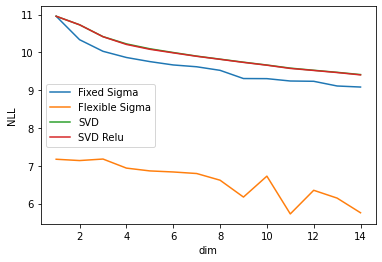

In [10]:
plt.plot(dims,fix_loss,label="Fixed Sigma")
plt.plot(dims,nonfix_loss,label="Flexible Sigma")
plt.plot(dims,svd_loss,label="SVD")
plt.plot(dims,svdrelu_loss,label="SVD Relu")
plt.xlabel("dim")
plt.ylabel("NLL")
plt.legend()
print("NMI Score")
print("{}\t {}\t {}\t {}\t {}".format("Dim","Nonfix","Fix","SVDRel","SVD"))
for i in range(len(dims)):
    print("{}\t {:.4f}\t {:.4f}\t {:.4f}\t {:.4f}".format(dims[i],nmi_nonfix[i-1],nmi_fix[i-1],nmi_svdrelu[i-1],nmi_svd[i-1]))
print("\n NLL0 = {}".format(loss0))

Text(0, 0.5, 'NLL')

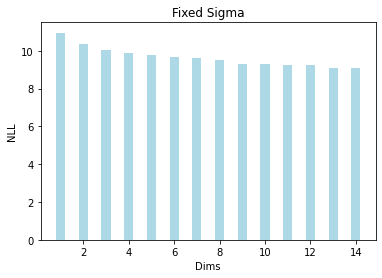

In [13]:
plt.bar(dims,fix_loss,color ='lightblue',width = 0.4)
plt.title("Fixed Sigma")
plt.xlabel("Dims")
plt.ylabel("NLL")

Text(0, 0.5, 'NLL')

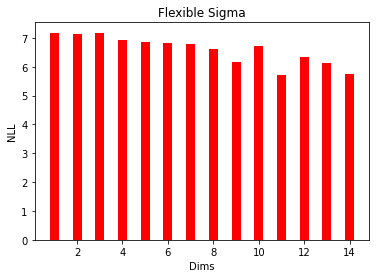

In [14]:
plt.bar(dims,nonfix_loss,color ='red',width = 0.4)
plt.title("Flexible Sigma")
plt.xlabel("Dims")
plt.ylabel("NLL")